# Range setting

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import PercentFormatter

In [64]:
# Parameters for normal distribution
mu = 0
sigma = 0.5
param = 35648
x_float = np.random.normal(mu, sigma, param)

mean/mu = 0.0012743087881488568 | std/sigma = 0.49583141688285143 


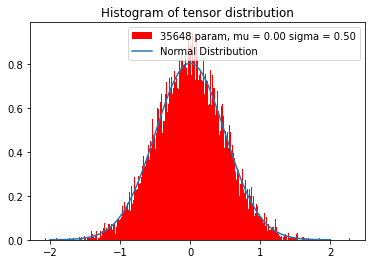

In [65]:

mu = np.mean(x_float)
sigma = np.std(x_float)

print("mean/mu = {} | std/sigma = {} ".format(mu, sigma))

plt.title(label="Histogram of tensor distribution")
plt.hist(x_float, bins=1000, density=True, label=(f"{param} param, mu = {mu:.2f} sigma = {sigma:.2f}"), color = ['red'])

# affichage de la courbe de la distribution normale pour comparaison
x = np.linspace(-2+mu,2+mu,1000)
y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2))

plt.plot(x, y, label="Normal Distribution")

plt.legend()
plt.show()


Fake symmetric quantization function

In [66]:
def fake_sym_quant(x_float, M=8, f_max = None):
    
    a_max  = (pow(2,M-1)) - 1

    if f_max == None:
        f_max  = np.max(np.abs(x_float))

    s_sym = (f_max)/(a_max)

    x_int = np.clip(np.round(x_float/s_sym), -a_max, a_max)

    x_sym_requant = s_sym*(x_int)

    return x_sym_requant

Fake asymmetric quantization function

In [67]:
def fake_asym_quant(x_float, M=8, f_min_asym = None, f_max_asym = None):
    a_min_asym  = - pow(2,M-1)
    a_max_asym  = pow(2,M-1) - 1

    if f_min_asym == None or f_max_asym == None :
        f_max_asym  = np.max(x_float)
        f_min_asym = np.min(x_float)

    s_asym = (f_max_asym - f_min_asym)/(a_max_asym - a_min_asym)

    z_int = - round(f_min_asym/s_asym) + a_min_asym

    x_int_asym = np.clip(np.round(x_float/s_asym)+z_int, a_min_asym, a_max_asym)

    x_asym_requant = s_asym*(x_int_asym-z_int)

    return x_asym_requant

Display error and MSE function

In [68]:
def error_and_MSE (x_float, x_sym_requant, x_asym_requant):
    
    MSE_sym = ((x_sym_requant - x_float)**2).mean()
    MSE_asym = ((x_asym_requant - x_float)**2).mean()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].hist(x_sym_requant - x_float, label=f"Sym error ; MSE = {MSE_sym:.4E}", bins=1000, color= ['blue'])
    axs[0].legend()
    axs[1].hist(x_asym_requant - x_float, label=f"Asym error ; MSE = {MSE_asym:.4E}", bins=1000, color= ['green'])
    axs[1].legend()
    plt.show()

Choose resolution

In [69]:
M = 8

### Min/max range setting

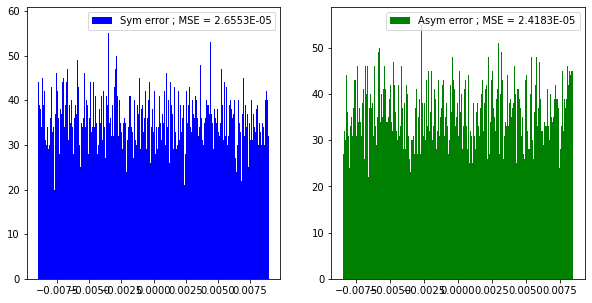

In [70]:
f_max_abs = np.max(np.abs(x_float))
f_max  = np.max(x_float)
f_min = np.min(x_float)
minmax_sym_requant = fake_sym_quant(x_float, M=M, f_max=f_max_abs)
minmax_asym_requant = fake_asym_quant(x_float, M=M, f_min_asym=f_min, f_max_asym=f_max)
error_and_MSE (x_float, minmax_sym_requant, minmax_asym_requant)

### Std based range setting

Original : min : -2.0643901572174936 max : 2.276729787287199
Std : min : -1.4862199418604054 max : 1.488768559436703


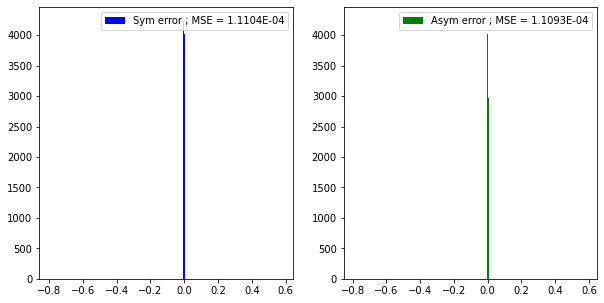

In [71]:
mu = np.mean(x_float)
std = np.std(x_float)
std_factor = 3

f_std_max  = std*std_factor+mu
f_std_min = -std*std_factor+mu
print("Original : min : {} max : {}".format(f_min, f_max))
print("Std : min : {} max : {}".format(f_std_min, f_std_max))
std_sym_requant = fake_sym_quant(x_float, M=M, f_max=f_std_max)
std_asym_requant = fake_asym_quant(x_float, M=M, f_min_asym=f_std_min, f_max_asym=f_std_max)
error_and_MSE (x_float, std_sym_requant, std_asym_requant)

### MSE range setting

Todo : asymmetric

In [72]:

def SymGaussianClippingSimulation(x_float, Alpha, sigma,bitWidth):
    simulations = []
    for alpha in Alpha:
        s = np.copy(x_float)
        Q = (2*alpha)/(2**bitWidth)
        s = fake_sym_quant(s, M = bitWidth, f_max=alpha)

        mse = ((s - x_float) ** 2).mean()
        simulations.append(mse)
    return simulations

Finding the best alpha for clipping

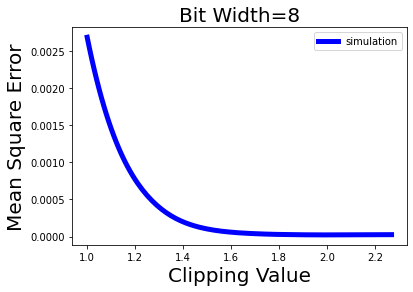

In [73]:
Alpha = np.arange(1, f_max_abs, 0.01)
std = np.std(x_float)

simulation = SymGaussianClippingSimulation(x_float, Alpha, std, M)

plt.plot(Alpha,simulation,'b', linewidth=5)
plt.legend(('simulation', 'analysis')); plt.ylabel('Mean Square Error', size=20) ; plt.xlabel('Clipping Value', size=20)
plt.title('Bit Width='+ str(M), size=20)
plt.show()


Taking the best alpha

Original : min : -2.0643901572174936 max : 2.276729787287199
Std : min : -2.020000000000001 max : 2.020000000000001


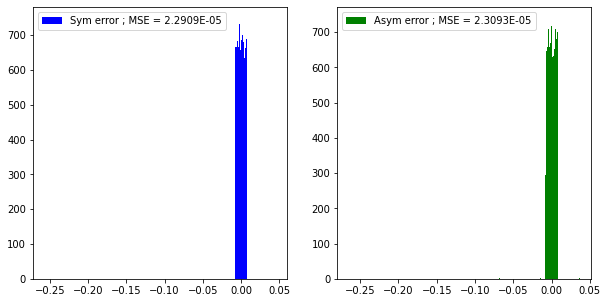

In [74]:
winner_alpha = Alpha[np.argmin(simulation)]
f_mse_min = -winner_alpha # to do for asymetric
f_mse_max = winner_alpha
print("Original : min : {} max : {}".format(f_min, f_max))
print("Std : min : {} max : {}".format(f_mse_min, f_mse_max))
mse_sym_requant = fake_sym_quant(x_float, M=M, f_max=f_mse_max)
mse_asym_requant = fake_asym_quant(x_float, M=M, f_min_asym=f_mse_min, f_max_asym=f_mse_max) # to do : asymetric
error_and_MSE (x_float, mse_sym_requant, mse_asym_requant)

Cross entropy for last layer (logits)

To do !

Compare all methods :

In [75]:
def MSE_compute(x, y): 
 return ((y - x)**2).mean()

In [76]:
MSE_minmax_sym = MSE_compute( minmax_sym_requant , x_float)
MSE_minmax_asym = MSE_compute( minmax_asym_requant , x_float)

print("Minmax")
print(" symmetric : ", MSE_minmax_sym,"asymmetric : ", MSE_minmax_asym)

MSE_std_sym = MSE_compute( std_sym_requant , x_float)
MSE_std_asym = MSE_compute( std_asym_requant , x_float)

print("std")
print(" symmetric : ", MSE_std_sym,"asymmetric : ", MSE_std_asym)

MSE_mse_sym = MSE_compute( mse_sym_requant , x_float)
MSE_mse_asym = MSE_compute( mse_asym_requant , x_float)

print("MSE asym not done")
print(" symmetric : ", MSE_mse_sym,"asymmetric : ", MSE_mse_asym)

Minmax
 symmetric :  2.655293637899812e-05 asymmetric :  2.418296348634836e-05
std
 symmetric :  0.00011104257937360938 asymmetric :  0.00011093335065149129
MSE asym not done
 symmetric :  2.290913982543707e-05 asymmetric :  2.309327931253475e-05
